<a href="https://colab.research.google.com/github/nicolashernandez/teaching_nlp/blob/main/static_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foreword

ne pas consulter les appendix. Elles contiennent des éléments de réponse.

# Introduction

L'objectif de ce notebook est de vous faire manipuler, observer et construire différentes modélisations de données statiques clairesemées et denses sur une tâche de classification : à savoir une tâche de classification binaire en sentiment (positif/négatif).

Le notebook est découpé en activités de 1 à 6. Les deux premières activités conduisent à observer les performances d'un classifieur entraîné sur des données clairsemées. L'activité 3 est un travail d'observation de modèles dense. Les activités 4 à 6 sont destinés à l'observation des performances d'un classifieur entraîné sur des données denses.

Plusieurs modélisations de données seront explorées
1. term frequency model
2. TF-IDF
3. pretrained word2vec, glove, FastText models
4. word2vec and FastText models trained from scratch on the target domain
5. doc2vec model trained from scratch on the target domain

Il vous est demandé de réaliser les tâches précédées par l'étiquette TODO. Quand toutes celles-ci auront été faites, s'il reste du temps vous pourrez faire les tâches TODO_FURTHER.  

La construction de certains modèles peut prendre du temps. Afin de  
- jouer avec les algorithmes de construction d'embeddings
- jouer avec les hyperparamètres des modèles (dimensions, ...)
- jouer avec les types de vectorisation
- jouer avec les prétraitements

je vous propose de travailler en petits groupes de 2-3 et de vous répartir des configurations à expérimenter.

On utilisera la base de données IMDB qui vient avec 3 partitions : train, test et unsupervised. La construction des modèles de données utilisera le jeu unsupervised. La construction des modèles de classification utilisera le jeu train tandis que l'évaluation se fera sur le jeu de test.

Pour les approches  de la vectorization 1 et 2, qui ne manipulent pas des vecteurs denses, vous pouvez travailler avec les jeux de données train et test au complet. Pour les autres approches, si les délais dépassent le quart d'heures alors travaillez sur l'échantillon (sample) de données de train et de test construit à partir du train original.

L'ordre de travail suggéré est le suivant :
1. Activité 1
2. Activité 2
3. Mener sur deux notebooks distincts d'un côté les activités 4, 5 et 6 selon les configurations de votre répartition et de l'autre l'activité 3 qui vous permet de patienter quand la machine calcule...

Ci-dessous un tableau non exhaustif des expériences à réaliser.


##  Experimental planning

TODO remplir la colonne *Acc*. Editez au besoin les autres colonnes et détaillez éventuellement les approches en plusieurs lignes.

TODO En fin de séance, réaliser une synthèse comparative des différentes approches et configuration. Cherchez notamment à observer et à expliquer les différences
* performance of sparse models
* sparse models vs dense models performance wrt number of dimension
* pretrained w2v-like model vs trained on domain data w2v-like models
* number of dimensions and performance for dense models
* difference of performance between w2v, glove, fastText and doc2vec models
* rôle of stemming preprocessing




| Model    | Pretrain           |  #Dim | Hyperparam | Train/Predict | Acc.  |
|----------|--------------------|-------|------------|---------------|-------|
| tf       | imdb-unsupervised  |    50 |                 | all    |       |
| tf       | imdb-unsupervised  |   100 |                 | all    |       |
| tf       | imdb-unsupervised  |   500 |                 | all    |       |
| tf       | imdb-unsupervised  |  1000 |                 | all    |       |
| tf       | imdb-unsupervised  |  5000 |                 | all    |       |
| tf       | imdb-unsupervised  | 10000 |                 | all    |       |
| tf       | imdb-unsupervised  | best  | stem            | all    |       |
| tf-idf   | imdb-unsupervised  |    50 |                 | all    |       |
| tf-idf   | imdb-unsupervised  |   100 |                 | all    |       |
| tf-idf   | imdb-unsupervised  |   500 |                 | all    |       |
| tf-idf   | imdb-unsupervised  |  1000 |                 | all    |       |
| tf-idf   | imdb-unsupervised  |  5000 |                 | all    |       |
| tf-idf   | imdb-unsupervised  | 10000 |                 | all    |       |
| tf-idf   | imdb-unsupervised  | best  | stem            | all    |       |
|----------|--------------------|-------|-----------------|--------|-------|
| glove    | twitter            |    25 |                 | sample |       |
| glove    | twitter            |    25 |                 | sample |       |
| glove    | twitter            |    50 |                 | sample |       |
| glove    | twitter            |   100 |                 | sample |       |
| fasttext | wiki-news-subwords |   300 |                 | sample |       |
| word2vec | google-news        |   300 |                 | sample |       |
|----------|--------------------|-------|-----------------|--------|-------|
| word2vec | imdb-unsupervised  |   100 |                 | sample |       |
| word2vec | imdb-unsupervised  |   100 |ws epoch min_count negative| sample |       |
| word2vec | imdb-unsupervised  |   300 |best             | sample |       |
| word2vec | imdb-unsupervised  |   500 |best             | sample |       |
| fasttext | imdb-unsupervised  |   100 |                 | sample |       |
| fasttext | imdb-unsupervised  |   100 |ws epoch min_count negative| sample |       |
| fasttext | imdb-unsupervised  |   300 |best             | sample |       |
| fasttext | imdb-unsupervised  |   500 |best             | sample |       |
|----------|--------------------|-------|-----------------|--------|-------|
| doc2vec  | imdb-unsupervised  |   100 |                 | sample |       |
| doc2vec  | imdb-unsupervised  |   300 |ws epoch min_count negative             | sample |       |
| doc2vec  | imdb-unsupervised  |   500 |best             | sample |       |



# A bit of theory

## Modèle "sac de mots" clairsemé

Le [**sac de mots** ou *BOW* pour *Bag Of Words* en anglais](https://fr.wikipedia.org/wiki/Sac_de_mots) est un modèle classique utilisé en Recherche d'Information (RI) pour représenter le contenu d'un document. Chaque document est décrit vis-à-vis d'un vocabulaire donné commun.

Différentes vues sont possibles :
- compter binairement si les mots du vocabulaire sont présents dans le document,
- compter les occurrences des mots du vocabulaire dans le document,
- pondérer les mots en tenant compte de leurs spécificités dans le document vis-à-vis des autres documents (on parle de pondération _tf-idf_).

La **vectorisation** est le processus qui désigne transformation des textes en vecteurs (de mots selon une modélisation *bow*).

On doit à [Karen Spärck Jones](https://fr.wikipedia.org/wiki/Karen_Sp%C3%A4rck_Jones) la proposition de la pondération _tf-idf_ des termes.
> « La spécificité d'un terme peut être quantifiée comme une fonction inverse du nombre de documents dans lesquels il apparaît. »

[Gérard Salton](https://fr.wikipedia.org/wiki/Gerard_Salton), quant à lui, est reconnu comme étant le père de la recherche d'information en ayant proposé une modélisation des documents dans un espace vectoriel.


* Karen Spärck Jones, « A statistical interpretation of term specificity and its application in retrieval », Journal of Documentation, vol. 28, no 1,‎ 1972, p. 11–21 (DOI 10.1108/eb026526)
* G. Salton , A. Wong , C. S. Yang, A vector space model for automatic indexing, Communications of the ACM, v.18 n.11, p. 613-620, novembre 1975

Par la suite nous utiliserons le module python sklearn qui offre des facilités pour pré-traiter (normaliser) et vectoriser aisément les textes.

On utilisera néanmoins un pré-traitement extérieur pour comparer différentes vectorisations concurrentes.

## Modèle dense statique

Les [**plongements de mots** (_word embeddings_ en anglais)](https://fr.wikipedia.org/wiki/Word_embedding) désignent le résultat de techniques récentes de vectorisation qui produisent des vecteurs denses de dimensions réduites, prédéfinies, et non corrélées avec la taille du vocabulaire (e.g. 100, 300, 500...).
Ces techniques reposent sur l'hypothèse distributionnelle de Harris qui veut que les mots apparaissant dans des contextes similaires ont des significations apparentées.

La méthode de référence est connue sous le nom [**Word2Vec** est attribuée à Mikolov et ses collègues (Google) en 2013](https://github.com/tmikolov/word2vec).
> Tomas Mikolov, Kai Chen, Greg Corrado et Jeffrey Dean, « Efficient Estimation of Word Representations in Vector Space », arXiv:1301.3781 [cs],‎ 16 janvier 2013

Les auteurs proposent deux architectures neuronales à 2 couches [CBOW (_continuous bag of words_) et SkipGram](https://fr.wikipedia.org/wiki/Word2vec#/media/Fichier:CBOW_eta_Skipgram.png).

> Le CBOW vise à prédire un mot étant donné son contexte. Skip-gram a une architecture symétrique visant à prédire les mots du contexte étant donné un mot en entrée. En pratique, le modèle CBOW est plus rapide à apprendre, mais le modèle skip-gram donne généralement de meilleurs résultats.

> La couche cachée contient quelques centraines de neurones et constitue à l'issue de l'entraînement le plongement représentant un mot. La couche de sortie permet d'implémenter une tâche de classification au moyen d'une softmax.

> L'apprentissage ne nécessite néanmoins aucun label, la vérité terrain étant directement déduite des données et plus particulièrement de la proximité des mots au sein du corpus d'entraînement. En ce sens, l'apprentissage de Word2vec constitue un apprentissage auto-supervisé.

Les vecteurs obtenus sont dits statiques (ou non contextuels) car ils restent tel quel quelle que soit l'occurrence du mot en contexte.

Un second modèle bien connu est celui de [**FastText** (Facebook)](https://github.com/facebookresearch/fastText) qui propose de traiter la variabilité morphologique des mots en construisant des vecteurs non pas pour des mots mais pour des sous-mots (séquence de caractères). Le lecteur d'un mot est la somme de tous les vecteurs des sous-mots le composant.

Cette approche est indépendante de la langue, et montre de meilleurs résultats que word2vec sur des tâches syntaxiques, surtout quand le corpus d'entraînement est petit. Word2vec est légèrement meilleur pour des tâches sémantiques. Un des avantage de FastText est de pouvoir fournir des vecteurs mêmes pour les mots hors vocabulaires.

Plusieurs **librairies permettent de créer, charger, sauver et manipuler des modèles de plongements de mots**. Nous allons utiliser _gensim_ qui permet aussi bien de travailler avec des modèles [word2vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py) que [fasttext](https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html#sphx-glr-auto-examples-tutorials-run-fasttext-py).  

Ici une [Comparison of FastText and Word2Vec](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Word2Vec_FastText_Comparison.ipynb)



# Environment

In [1]:
from tqdm import tqdm
import pandas as pd
pd.options.display.max_colwidth = 200
import numpy as np
import re
import json
import sys

# Dataset: IMDB

For our experiment, we use the [Large Movie Review Dataset](https://huggingface.co/datasets/stanfordnlp/imdb) from [Learning Word Vectors for Sentiment Analysis](https://aclanthology.org/P11-1015) (Maas et al., ACL 2011).

The dataset was developed for binary sentiment classification task.

It contains
* a set of 25,000 highly polar movie reviews for training,
* 25,000 for testing
* and additional 50,000 unlabeled data for use as well.

## Load and preprocess the raw dataset

**load the dataset online**



In [2]:
!pip install datasets

from datasets import load_dataset

imdb_dataset = load_dataset("stanfordnlp/imdb")
imdb_dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

**pandas dataframe creation for each splits** (train, test and unsupervised)

In [3]:
train_df = imdb_dataset['train'].to_pandas()
test_df = imdb_dataset['test'].to_pandas()
unsupervised_df = imdb_dataset['unsupervised'].to_pandas()

train_df

,text,label
0,I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if i...,0
1,"""I Am Curious: Yellow"" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim t...",0
2,If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touc...,0
3,"This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead.<br /><br />The film has two strong elements and those are, (1) the realistic acting (2) the i...",0
4,"Oh, brother...after hearing about this ridiculous film for umpteen years all I can think of is that old Peggy Lee song..<br /><br />""Is that all there is??"" ...I was just an early teen when this s...",0
...,...,...
24995,"A hit at the time but now better categorised as an Australian cult film. The humour is broad, unsubtle and, in the final scene where a BBC studio fire is extinguished by urinating on it, crude. Co...",1
24996,"I love this movie like no other. Another time I will try to explain its virtues to the uninitiated, but for the moment let me quote a few of pieces the remarkable dialogue, which, please remember,...",1
24997,"This film and it's sequel Barry Mckenzie holds his own, are the two greatest comedies to ever be produced. A great story a young Aussie bloke travels to england to claim his inheritance and meets ...",1
24998,"'The Adventures Of Barry McKenzie' started life as a satirical comic strip in 'Private Eye', written by Barry Humphries and based on an idea by Peter Cook. McKenzie ( 'Bazza' to his friends ) is a...",1


**preprocessing**

sklearn vectorizers can perform preprocessing while vectorizing a text (see the documentation). gensim offer external methods to do so (see the documentation [preprocessing gensim methods](https://radimrehurek.com/gensim/parsing/preprocessing.html)).

To compare vectorization, it is important to apply the same preprocessing.

Instead of using a home made method we choose to use a gensim method to be compliant with the gensim word2vec pretrained models.

The method applies a list of chosen filters. By default: strip_tags(), strip_punctuation(),  strip_multiple_whitespaces(), strip_numeric(), remove_stopwords(), strip_short(), stem_text().


TODO_FURTHER: you may want to change the preprocessing later. For example, add `stem_text` !

In [17]:
# create nlp preprocessing filters
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import stem_text
my_filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_numeric, strip_short] # , stem_text

# preprocess
from gensim.parsing.preprocessing import preprocess_string
%time train_df['preprocessed_text'] = train_df['text'].apply(lambda s : ' '.join(preprocess_string(s, filters = my_filters)))
%time test_df['preprocessed_text'] = test_df['text'].apply(lambda s : ' '.join(preprocess_string(s, filters = my_filters)))
%time unsupervised_df['preprocessed_text'] = unsupervised_df['text'].apply(lambda s : ' '.join(preprocess_string(s, filters = my_filters)))

train_df

CPU times: user 8.28 s, sys: 25.4 ms, total: 8.31 s
Wall time: 8.83 s
CPU times: user 8.21 s, sys: 41 ms, total: 8.25 s
Wall time: 8.35 s
CPU times: user 19.7 s, sys: 137 ms, total: 19.8 s
Wall time: 22.3 s


,text,label,preprocessed_text
0,I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if i...,0,rented curious yellow video store controversy surrounded released heard seized customs tried enter country fan films considered controversial plot centered young swedish drama student named lena w...
1,"""I Am Curious: Yellow"" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim t...",0,curious yellow risible pretentious steaming pile matter political views film hardly taken seriously level claim frontal male nudity automatic isn true seen rated films male nudity granted offer fl...
2,If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touc...,0,avoid making type film future film interesting experiment tells cogent story feel virtuous sitting touches important issues discernable motive viewer comes away new perspectives comes mind wanders...
3,"This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instead.<br /><br />The film has two strong elements and those are, (1) the realistic acting (2) the i...",0,film probably inspired godard masculin féminin urge film instead film strong elements realistic acting impressive undeservedly good photo apart strikes endless stream silliness lena nyman annoying...
4,"Oh, brother...after hearing about this ridiculous film for umpteen years all I can think of is that old Peggy Lee song..<br /><br />""Is that all there is??"" ...I was just an early teen when this s...",0,brother hearing ridiculous film umpteen years think old peggy lee song early teen smoked fish hit young theater manage sneak goodbye columbus screening local film museum beckoned finally film old ...
...,...,...,...
24995,"A hit at the time but now better categorised as an Australian cult film. The humour is broad, unsubtle and, in the final scene where a BBC studio fire is extinguished by urinating on it, crude. Co...",1,hit time better categorised australian cult film humour broad unsubtle final scene bbc studio extinguished urinating crude contains cliche traditional australian pilgrimage old country cliche rapa...
24996,"I love this movie like no other. Another time I will try to explain its virtues to the uninitiated, but for the moment let me quote a few of pieces the remarkable dialogue, which, please remember,...",1,love movie like time try explain virtues uninitiated moment let quote pieces remarkable dialogue remember tongue cheek aussies poms understand title song lyric sink beer pick queer latest double b...
24997,"This film and it's sequel Barry Mckenzie holds his own, are the two greatest comedies to ever be produced. A great story a young Aussie bloke travels to england to claim his inheritance and meets ...",1,film sequel barry mckenzie holds greatest comedies produced great story young aussie bloke travels england claim inheritance meets mates loveable innocent chock block great sayings needs drink bad...
24998,"'The Adventures Of Barry McKenzie' started life as a satirical comic strip in 'Private Eye', written by Barry Humphries and based on an idea by Peter Cook. McKenzie ( 'Bazza' to his friends ) is a...",1,adventures barry mckenzie started life satirical comic strip private eye written barry humphries based idea peter cook mckenzie bazza friends lanky loud hat wearing australian main interests life ...


**create split sets**

In [18]:
#
X_train = train_df['preprocessed_text']
Y_train = train_df['label']
X_test = test_df['preprocessed_text']
Y_test = test_df['label']
X_unsupervised = unsupervised_df['preprocessed_text']

print (X_train[:5], Y_train[:5])

0    rented curious yellow video store controversy surrounded released heard seized customs tried enter country fan films considered controversial plot centered young swedish drama student named lena w...
1    curious yellow risible pretentious steaming pile matter political views film hardly taken seriously level claim frontal male nudity automatic isn true seen rated films male nudity granted offer fl...
2    avoid making type film future film interesting experiment tells cogent story feel virtuous sitting touches important issues discernable motive viewer comes away new perspectives comes mind wanders...
3    film probably inspired godard masculin féminin urge film instead film strong elements realistic acting impressive undeservedly good photo apart strikes endless stream silliness lena nyman annoying...
4    brother hearing ridiculous film umpteen years think old peggy lee song early teen smoked fish hit young theater manage sneak goodbye columbus screening local film museum becko

In [19]:
# to numpy
X_train_np = np.array(X_train)
Y_train_np = np.array(Y_train)
X_test_np = np.array(X_test)
Y_test_np = np.array(Y_test)
X_unsupervised_np = np.array(X_unsupervised)

print (X_train_np[:5], '\n', Y_train_np[:5])

['rented curious yellow video store controversy surrounded released heard seized customs tried enter country fan films considered controversial plot centered young swedish drama student named lena wants learn life particular wants focus attentions making sort documentary average swede thought certain political issues vietnam war race issues united states asking politicians ordinary denizens stockholm opinions politics sex drama teacher classmates married men kills curious yellow years ago considered pornographic sex nudity scenes far shot like cheaply porno countrymen mind shocking reality sex nudity major staple swedish cinema ingmar bergman arguably answer good old boy john ford sex scenes films commend filmmakers fact sex shown film shown artistic purposes shock people money shown pornographic theaters america curious yellow good film wanting study meat potatoes pun intended swedish cinema film plot'
 'curious yellow risible pretentious steaming pile matter political views film hard

## Sample

In order to make the process faster, work on a sample

In [7]:
# select a sample then split it into training and testing sets
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

sample_data = resample(train_df, n_samples = 1000, random_state = 42)
print (sample_data.shape)
print (sample_data.columns)

X_train, X_test, Y_train, Y_test = train_test_split(sample_data['preprocessed_text'], sample_data['label'], test_size=0.2, random_state=45 )
X_train_np = np.array(X_train)
Y_train_np = np.array(Y_train)
X_test_np = np.array(X_test)
Y_test_np = np.array(Y_test)

# FURTHER  perform your own preprocess on the raw dataset

(1000, 3)
Index(['text', 'label', 'preprocessed_text'], dtype='object')


In [8]:
from collections import Counter
print ('Y_train distribution', list(Counter(Y_train).items()))
print ('Y_test distribution', list(Counter(Y_test).items()))

Y_train distribution [(0, 388), (1, 412)]
Y_test distribution [(1, 92), (0, 108)]


# Activity 1: Vectorization 1 via term frequency model

Given train, test and unsupervised datasets.

1. vectorize X_train and X_test using vocabulary learnt on X_unsupervised
  - First, fit the vectorizer on the raw data (here *imdb-unsupervised*) to learn a vocabulary dictionary of tokens.
  - Then, transform the train and the test documents to document-term matrix. This will extract token counts out of the train and the test text documents using the vocabulary fitted with the fit method on the raw data. See [CountVectorizer API](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to read more on the fit, transform and the fit_transform methods
2. train a classification model (here a logistic) on the train data
3. use the model learnt to predict the classes of the tests instances
4. evaluate the prediction

1. Vectorize the datasets

Le code suivant réalise une vectorisation du corpus en comptant les occurrences des mots. La vectorisation prend en charge la construction d'un vocabulaire sur le corpus ainsi que quelques pré-traitements de normalisation linguistiques. Enfin le résultat de la vectorisation est affiché sous la forme d'une matrice **document-terme** (les documents sont en ligne et les mots en colonne).
Nous aurons une matrice de dimension _nb de documents * taille du vocabulaire_.

Here we limit the number of dimensions to ```max_features=1000```.

Do not hesite to have a look at all the parameters of [CountVectorizer](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [20]:
# 1
from sklearn.feature_extraction.text import CountVectorizer

# define the vectorizer
DIMENSION_SIZE = 1000
count_vectorizer = CountVectorizer(stop_words= None, max_features=DIMENSION_SIZE) #stop_words='english')

# display the configuration of the vectorizer
print (count_vectorizer)

# 1.1 Learn the vocabulary (fit)
X_unsupervised_counter_matrix = count_vectorizer.fit(X_unsupervised_np)

# 1.2 Transform documents to document-term matrix (i.e. perform the vectorization) by using Vocabulary learned
X_train_counter_matrix = count_vectorizer.transform(X_train_np)
X_test_counter_matrix = count_vectorizer.transform(X_test_np)
print ('X_train dimensions:', X_train_counter_matrix.get_shape(), 'Taille mémoire', sys.getsizeof(X_train_counter_matrix))
print ('X_test dimensions:', X_test_counter_matrix.get_shape(), 'Taille mémoire', sys.getsizeof(X_test_counter_matrix))

# get all unique words in the corpus (the vocabulary and also the names of the matrix columns/features)
vocab = count_vectorizer.get_feature_names_out() # .get_feature_names() # for sklearn_version >= 1.0
print ('Vocabulary size:', len(vocab))

# show document-term matrix
X_train_counter_matrix_array = X_train_counter_matrix.toarray()
pd.DataFrame(X_train_counter_matrix_array, columns=vocab)

CountVectorizer(max_features=1000)
X_train dimensions: (25000, 1000) Taille mémoire 48
X_test dimensions: (25000, 1000) Taille mémoire 48
Vocabulary size: 1000


,ability,able,absolutely,accent,act,acted,acting,action,actor,actors,...,wrong,wrote,yeah,year,years,yes,york,young,younger,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,3,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24997,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0


2. **train** a classifier

In [21]:
# 2.
from sklearn.linear_model import LogisticRegression
LR_counter_model = LogisticRegression().fit(X_train_counter_matrix, Y_train_np)

3. use the classifier to **predict**

In [22]:
# 3.
Y_test_prediction = LR_counter_model.predict(X_test_counter_matrix)

4. evaluate

In [23]:
# 4.
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(Y_test,Y_test_prediction))
print(classification_report(Y_test,Y_test_prediction))

0.8504
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12500
           1       0.84      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



# Activity 2: Vectorization 2 via TF-IDF model

La vectorisation avec occurrences présente des limites lorsqu'elle est utilisée sur de large corpus. En effet, le modèle présume que l'importance des mots est fonction de sa fréquence et qu'un mot plus fréquent qu'un autre dans un document est plus discriminant que l'autre. Le problème intervient quand un mot fréquent, supposé important, apparaît dans plusieurs documents. Le fait qu'il apparaisse dans plusieurs documents peut au final le rendre moins discriminant que d'autres pourtant moins fréquents. Le problème vient du fait que l'on prenne des valeurs absolues.

Le modèle **TF-IDF** vise à solutionner ce problème en normalisant le compte des occurrences. TF-IDF correspond à _Term Frequency-Inverse Document Frequency_.

On définit le TF-IDF comme suit: `tfidf = tf x idf`
* `tfidf(w, D)` est le score TF-IDF du mot `w` dans le document `D`
* `tf(w, D)` représente le nombre d'occurrence du terme `w` dans le document `D`
* `idf(w, D)` représente la fréquence inverse documentaire du terme `w`, qui peut être calculée comme le log du nombre total de documents dans le corpus `C` divisé par la fréquence documentaire du terme `w` (i.e. le nombre de documents du corpus `C` dans lequel le terme `w` se produit).


Here the definition of the [TfidfVectorizer](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

TODO Implement the TfidfVectorizer vectorizer, train, predict and evaluate a LogisticRegression using this vectorizer

TODO Play with the number of dimensions (50, 100, 500, 1000, 5000, 10000...)  and observe the performance

In [ ]:
# 1. define the vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
DIMENSION_SIZE = 50 #
# TODO
%time tfidf_vectorizer = None

# 1.1 Learn the vocabulary (fit)
# TODO
X_unsupervised_tfidf_matrix = None

# 1.2 transform documents to document-term matrix (i.e. perform the vectorization)
# TODO
X_train_tfidf_matrix = None
X_test_tfidf_matrix = None

# 2. train
# TODO

# 3. predict
# TODO

# 4. evaluate
# TODO


# Activity 3: Play with static dense models

## Load existing pretrain models

Le dépôt [gensim-data](https://github.com/RaRe-Technologies/gensim-data) contient quelques corpus et modèles pré-entraînés librement disponibles.
Jean-Philippe Fauconnier met des [modèles word2vec à disposition pour le français ](https://fauconnier.github.io/#data).


The model size depends on the number of dimensions. Higher dimensions model will take more time to download.

TODO select a model (start with a small model). Optionaly, uncomment the code to show info about the available gensim models/datasets.


In [26]:
import gensim.downloader as gensim_api

# uncomment to show info about available models/datasets
# print(json.dumps(gensim_api.info(), indent=4))

# load a w2v_model
#%time glove_twitter_25_model = gensim_api.load("glove-twitter-25")         # 1193514 vectors # 104 MB
#%time glove_twitter_50_model = gensim_api.load("glove-twitter-50")         # 1193514 vectors # 199 MB
%time glove_twitter_100_model = gensim_api.load("glove-twitter-100")        # 1193514 vectors # 387 MB
#%time glove_wiki_gigaword_100_model = gensim_api.load("glove-wiki-gigaword-100") # 400000  vectors # 128 MB
#%time ft_wiki_news_300_model = gensim_api.load("fasttext-wiki-news-subwords-300 ") # 999999  vectors # 958 MB
#%time w2v_gn_300_model = gensim_api.load('word2vec-google-news-300') # 3000000 vectors # 1662 MB

# generic variable in the following codes
w2v_model = glove_twitter_100_model

[==================================================] 100.0% 387.1/387.1MB downloaded
CPU times: user 4min 4s, sys: 14.7 s, total: 4min 19s
Wall time: 6min 49s


## Get most similar words and search for bias

Pour chaque question ci-dessous, jouez le jeu et prenez le temps faire des propositions de réponses avant d'exécuter le code qui permettra de consulter la connaissance du modèle et connaître ce qu'il répondrait.

**Si je vous dis 'king', vous pensez à quoi ?**

TODO Faire quelques propositions de synonymes ou de mots substituables sémantiquement proches. La méthode `most_similar` affichera les 10 mots les plus proches d'un mot donné, du plus similaire au moins similaire, avec pour chacun un score de similarité avec le mot donné (scores décroissants donc).

In [ ]:
# obtenir les mots similaires à 1 mot
w2v_model.most_similar("king")

Si je vous demande de me donner des mots relatifs à des 'dessert' et 'cake', à quoi pensez-vous ? Pour information, la méthode accepte une liste de mots en paramètres.

In [ ]:
# obtenir les mots similaires relatifs à une liste
w2v_model.most_similar(['dessert', 'cake'])

Si j'ajoute les vecteurs de roi et de femme et que je retire le vecteur homme qu'est ce que j'obtiens ? Répondez avant d'exécuter le code ci-dessous.



In [ ]:
# Si j'ajoute les vecteurs de roi et de femme et que je retire le vecteur homme qu'est ce que j'obtiens ?
w2v_model.most_similar(positive = ['king', 'woman'], negative = ['man'])

One of the open science value is the access to knowledge to anyone regardless his/her location, nationality, race, age, gender, income, socio-economic circumstance, career stage, discipline, language, religion, disability, ethnicity, migratory status...

Below an example of association which desmonstrates some gender bias:

In [27]:
print (w2v_model.most_similar(positive =['strength', 'man'], negative = ['woman']))
print (w2v_model.most_similar(positive =['strength', 'woman'], negative = ['man']))

[('faith', 0.589231550693512), ('god', 0.5837271213531494), ('lord', 0.5627992153167725), ('rest', 0.5500725507736206), ('training', 0.5458858013153076), ('joy', 0.5310255885124207), ('power', 0.5269313454627991), ('determination', 0.5251309871673584), ('patience', 0.5244085192680359), ('motivation', 0.5203278064727783)]
[('confidence', 0.6551448702812195), ('humility', 0.643629252910614), ('requires', 0.6390582919120789), ('faith', 0.6357606649398804), ('ability', 0.6332043409347534), ('discipline', 0.6117353439331055), ('inner', 0.6078113913536072), ('patience', 0.6021292209625244), ('powerful', 0.6009049415588379), ('qualities', 0.5983656048774719)]


TODO: by using the `most_similar` method (with/without negative), show that the model contains some bias in at least three dimensions. Vous pouvez vous aider du visualiseur 2D ci-dessous pour cartographier les mots qui vous interrogent.


## Visualiser les plongements lexicaux dans un graph en 2D

Pour ce faire, il faut transformer les vecteurs de n dimensions à des vecteurs à 2 dimensions. La réduction des dimensions est effectuée à l'aide d'une [analyse en composantes principales (ACP ou PCA pour _Principal Component Analysis_ en anglais)](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales).

TODO Observer si la synonymie, la morphologie, les biais sont "marqués" spatialement (même zone ou position relative). Vous pouvez tester avec d'autres listes de mots.


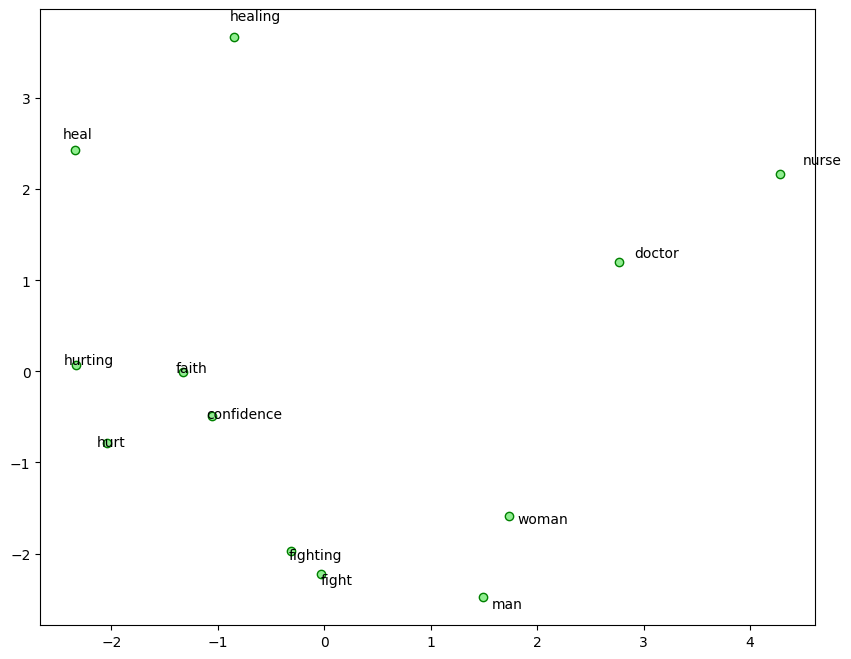

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
#words = sum([[k] + v for k, v in similar_words.items()], [])
#words = ['roi', 'reine']
# soit une liste de mots à projeter
#words = ['palais', 'église', 'cathédrale', 'monastère', 'route', 'train', 'bateau', 'calèche', 'voiture', 'armée', 'soldat', 'bataille']
words = ['man', 'woman', 'doctor', 'nurse', 'faith', 'confidence', 'heal', 'hurt', 'healing', 'hurting', 'fight', 'fighting']

wvs = w2v_model[words]

# Application de la transformation PCA qui réduit les vecteurs à 2 dimensions
pca = PCA(n_components=2)
#np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

# Affichage
fig = plt.figure(figsize=(10, 8))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x*1.05, y*1.05), xytext=(0, 0), textcoords='offset points')

## Visualiser les plongements lexicaux en 3D dynamique à l'aide du _projector de tensorflow_

Le _[projector de tensorflow](http://projector.tensorflow.org/)_ de tensorflow vous permet de visualiser vos modèles ou des modèles existants.




TODO utiliser un modèle disponible comme Word2Vec 10K, observer les voisins de mots éthiquement incorrects (search puis isolate en haut à droite). Relevez vous des associations douteuses ?

# Activity 4: Vectorization 3 using existing pretrained word static dense models


## Load existing pretrain models

Le dépôt [gensim-data](https://github.com/RaRe-Technologies/gensim-data) contient quelques corpus et modèles pré-entraînés librement disponibles.
Jean-Philippe Fauconnier met des [modèles word2vec à disposition pour le français ](https://fauconnier.github.io/#data).


The model size depends on the number of dimensions. Higher dimensions model will take more time to download.

TODO select a model (start with a small model). Optionaly, uncomment the code to show info about the available gensim models/datasets.


In [ ]:
import gensim.downloader as gensim_api

# uncomment to show info about available models/datasets
# print(json.dumps(gensim_api.info(), indent=4))

# load a w2v_model
#%time glove_twitter_25_model = gensim_api.load("glove-twitter-25")         # 1193514 vectors # 104 MB
#%time glove_twitter_50_model = gensim_api.load("glove-twitter-50")         # 1193514 vectors # 199 MB
%time glove_twitter_100_model = gensim_api.load("glove-twitter-100")        # 1193514 vectors # 387 MB
#%time glove_wiki_gigaword_100_model = gensim_api.load("glove-wiki-gigaword-100") # 400000  vectors # 128 MB
#%time ft_wiki_news_300_model = gensim_api.load("fasttext-wiki-news-subwords-300 ") # 999999  vectors # 958 MB
#%time w2v_gn_300_model = gensim_api.load('word2vec-google-news-300') # 3000000 vectors # 1662 MB

# generic variable in the following codes
w2v_model = glove_twitter_100_model

CPU times: user 1min 42s, sys: 2.03 s, total: 1min 44s
Wall time: 1min 45s


## Build a document vectorizer based on a word dense model

**Simple w2v methods to learn to handle the API**

TODO Allign each instruction with the right comment

In [ ]:
a_word = "king"

# comments
print ('Model shape (|Vocabulary|,|dimensions|):')
print ('A sample of the dictionary of word2index:')
print ('Index of a given word "', a_word, '":')
print ('Vector of the word')
print ('Vector of the word by direct access to the matrix')
print ('Mean of a list of vectors:')
print ('List of words similar to the given vector')

# instructions
print (w2v_model.get_vector('word'))
a_mean_vector = w2v_model.get_mean_vector(["animal", "water"])
print (a_mean_vector)
print (w2v_model.vectors.shape)
print (w2v_model.similar_by_vector( a_mean_vector))
print(list(w2v_model.key_to_index.items())[:15])
print(w2v_model.vectors[w2v_model.key_to_index['word']])
print(w2v_model.key_to_index[a_word])

**Document vectorizer based on a w2v-like model**

TODO implement the vectorizer method using a w2v-like model (word2vec, glove, fastText)

The basic idea of the algorithm is to parse the list of documents to vectorize. For each document,
- tokenize the document
- create a list of token present in the dictionary of the model
- turn this list of tokens into a list of vectors of these tokens
- compute the mean of these vectors
the resulting mean will be used to represent the document

In [41]:
def w2v_vectorizer(w2v_model, X):
  """
  Vectorize each document of the X list.

  Args:
      param1: the w2v like model to use.
      param2: the list of documents (eachone a single string).

  Returns:
      Description of the return the numpy 'stack' of the document vectors.
  """
  # Your code here
  pass


1. vectorize (backup option)
2. train
3. predict
4. evaluate

In [42]:
#w2v_model = glove_twitter_100_model

# Vectorize
%time X_train_w2v_matrix = w2v_vectorizer(w2v_model, X_train)
print (X_train_w2v_matrix.shape)

%time X_test_w2v_matrix = w2v_vectorizer(w2v_model, X_test)
print (X_test_w2v_matrix.shape)

print (Y_train_np.shape)

# Backup
#import pickle
#with open('X_train_w2v_matrix.pkl', 'wb') as f:
#  pickle.dump(X_train_w2v_matrix, f)
#
#with open('X_test_w2v_matrix.pkl', 'wb') as f:
#  pickle.dump(X_test_w2v_matrix, f)

# train
from sklearn.linear_model import LogisticRegression
LR_w2v_model = LogisticRegression().fit(X_train_w2v_matrix, Y_train_np)

# predict
Y_test_prediction = LR_w2v_model.predict(X_test_w2v_matrix)

# evaluate
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(Y_test,Y_test_prediction))
print(classification_report(Y_test,Y_test_prediction))

100%|██████████| 25000/25000 [00:27<00:00, 919.54it/s]


CPU times: user 25.3 s, sys: 185 ms, total: 25.5 s
Wall time: 27.3 s
(25000, 100)


100%|██████████| 25000/25000 [00:42<00:00, 593.84it/s] 


CPU times: user 30.5 s, sys: 247 ms, total: 30.7 s
Wall time: 42.2 s
(25000, 100)
(25000,)
0.79068
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     12500
           1       0.80      0.78      0.79     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



 # Activity 5: Vectorization 4 by pretraining a word static dense model


Word2Vec et FastText prennent tous deux un corpus normalisé segmenté en phrases et tokenisés en mots.

Pour ce faire nous allons utiliser le dataset *unsupervised*.

TODO tokeniser le dataset unsupervised


In [ ]:
X_tokenized_unsupervised = None
#print (X_tokenized_unsupervised[:2])

[['preciou', 'littl', 'diamond', 'plai', 'script', 'excel', 'compar', 'movi', 'mayb', 'movi', 'leon', 'wonderfulli', 'plai', 'jean', 'reno', 'natali', 'portman', 'best', 'movi', 'ann', 'parillaud', 'plai', 'franki', 'starlight', 'speak', 'english', 'mean', 'stori', 'young', 'punk', 'girl', 'nikita', 'taken', 'deprav', 'world', 'secret', 'govern', 'forc', 'exception', 'american', 'mind', 'point', 'return', 'especi', 'femm', 'nikita', 'seri', 'compar', 'origin', 'believ', 'trash', 'video', 'bui', 'rent', 'bui', 'btw', 'bewar', 'subtitl', 'compani', 'translat', 'releas', 'disgrac', 'understand', 'french', 'dub', 'version', 'regret', 'later'], ['favourit', 'film', 'time', 'comment', 'taken', 'lightli', 'probabl', 'watch', 'far', 'film', 'healthi', 'love', 'saw', 'femm', 'nikita', 'nearli', 'year', 'ago', 'manag', 'absolut', 'favourit', 'incred', 'stylish', 'sexi', 'thriller', 'luc', 'besson', 'great', 'flair', 'impecc', 'direct', 'fashion', 'appropri', 'usag', 'music', 'make', 'watchabl', 

Hyper-paramètres les plus communs du constructeur de la [classe Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) :

* `corpus`: List of tokenized sentences
* `size` : Dimensionality of the word vectors (default: 100)
* `window` : Maximum distance between the current and predicted word within a sentence
* `sg` : Training algorithm: 1 for skip-gram; otherwise CBOW
* `iter` :  Number of iterations (epochs) over the corpus
* `workers` Use these many worker threads to train the model (=faster training with multicore machines)



cette définition peut servir à la fois pour Word2Vec ou FastText


In [44]:
# Set values for various parameters
lr = 0.05   # Learning rate
dim = 100   # Word vector dimensionality
ws = 5      # Context window size
epoch = 5
minCount = 5 # Minimum word count
neg = 5
loss = 'ns'
t = 1e-4
#sample = 1e-3   # Downsample setting for frequent words
sg=1

params = {
    'alpha': lr,
    'vector_size': dim,
    'window': ws,
    'epochs': epoch,
    'min_count': minCount,
    'sample': t,
    'sg': 1,
    'hs': 0,
    'negative': neg
}

Construction des modèles. Observez la rapidité compte tenu du nombre de mots.

## pretrain a w2v

peut prendre de 3 à 5 minutes pour 100 à 300 dimensions

TODO implementer et exécuter le modèle Word2Vec  sur le corpus unsupervised (tokenisé).

In [ ]:
from gensim.models import Word2Vec, KeyedVectors

#
%time w2v_model =  None # TODO

# save the model
# !mkdir -p models
# w2v_model_path = 'models/w2v_imdb_unsupervised_HYPER_PARAM.bin'
# w2v_model.save(w2v_model_path)

CPU times: user 17min 22s, sys: 2.12 s, total: 17min 24s
Wall time: 10min 46s


Vectorize, train, predict and evaluate

In [ ]:
w2v_model = w2v_model.wv

In [46]:
# Vectorization
%time X_train_w2v_matrix = w2v_vectorizer(w2v_model, X_train)
%time X_test_w2v_matrix = w2v_vectorizer(w2v_model, X_test)

print (X_train_w2v_matrix.shape)
print (X_test_w2v_matrix.shape)
print (Y_train_np.shape)

# train # TODO
from sklearn.linear_model import LogisticRegression
%time LR_w2v_model = LogisticRegression().fit(X_train_w2v_matrix, Y_train_np)

# predict # TODO
%time Y_test_prediction = LR_w2v_model.predict(X_test_w2v_matrix)

# evaluate # TODO
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(Y_test,Y_test_prediction))
print(classification_report(Y_test,Y_test_prediction))

  0%|          | 0/25000 [00:00<?, ?it/s]


AttributeError: 'Word2Vec' object has no attribute 'get_mean_vector'

  0%|          | 0/25000 [00:00<?, ?it/s]


AttributeError: 'Word2Vec' object has no attribute 'get_mean_vector'

(25000, 100)
(25000, 100)
(25000,)
CPU times: user 549 ms, sys: 127 ms, total: 677 ms
Wall time: 386 ms
CPU times: user 11 ms, sys: 14.8 ms, total: 25.8 ms
Wall time: 12.9 ms
0.79068
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     12500
           1       0.80      0.78      0.79     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



## pretrain FastText

Peut prendre pour 100 dimensions 8-15 minutes, 300 dimensions 11-22 minutes, 500 dimensions 23-40 minutes.

TODO implementer et exécuter le modèle FastText sur le corpus unsupervised (tokenisé).

In [ ]:
from gensim.models.fasttext import FastText

#
%time ft_model = None # TODO

# save the model
#!mkdir -p models
#ft_model_path = 'models/ft_imdb_unsupervised_HYPER_PARAM.bin'
#ft_model.save(ft_model_path)

CPU times: user 39min 12s, sys: 7.47 s, total: 39min 19s
Wall time: 23min 30s


Vectorize, train, predict and evaluate

In [ ]:
w2v_model = ft_model.wv

# Vectorization
#%time X_train_w2v_matrix = w2v_vectorizer(w2v_model, X_train)
#%time X_test_w2v_matrix = w2v_vectorizer(w2v_model, X_test)
%time X_train_w2v_matrix = my_w2v_vectorizer(w2v_model, X_train)
%time X_test_w2v_matrix = my_w2v_vectorizer(w2v_model, X_test)


# train # TODO
from sklearn.linear_model import LogisticRegression
%time LR_w2v_model = LogisticRegression().fit(X_train_w2v_matrix, Y_train_np)

# predict # TODO
%time Y_test_prediction = LR_w2v_model.predict(X_test_w2v_matrix)

# evaluate # TODO
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(Y_test,Y_test_prediction))
print(classification_report(Y_test,Y_test_prediction))

100%|██████████| 25000/25000 [00:30<00:00, 832.59it/s]


CPU times: user 29.2 s, sys: 428 ms, total: 29.6 s
Wall time: 30.1 s


100%|██████████| 25000/25000 [00:28<00:00, 888.37it/s]


CPU times: user 27.5 s, sys: 340 ms, total: 27.8 s
Wall time: 28.2 s
CPU times: user 563 ms, sys: 134 ms, total: 696 ms
Wall time: 415 ms
CPU times: user 53.8 ms, sys: 235 ms, total: 289 ms
Wall time: 160 ms
0.84536
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     12500
           1       0.84      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



# Activity 6: Vectorization 5 using doc2vec

La documentation de [doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html) décrit comment construire un modèle doc2vec à partir d'une collection de documents et d'inférer (vectoriser) un document.







TODO construire un modèle doc2vec à partir de la collection X_unsupervised. Les documents ont besoin des d'être tokenisé en entrée de TaggedDocument. Vous êtes libre de tester différents hyperparamètres (e.g. 100, 300, 500 dimensions et différents min_count de 1 à 5) :  Tokenize the raw data, turn it into TaggedDocument then build a doc2vec model from it

In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


CPU times: user 8min 7s, sys: 15.7 s, total: 8min 23s
Wall time: 6min 21s


Vectorize

TODO vectorize X_train and X_test documents

In [ ]:
# Infer vector for new documents:
#
X_train_d2v_matrix = list()
X_train_d2v_matrix_np = None

#
X_test_d2v_matrix = list()
X_test_d2v_matrix_np = None

100%|██████████| 200/200 [00:02<00:00, 79.04it/s]


Train, predict, and evaluate

In [ ]:
# train
from sklearn.linear_model import LogisticRegression
%time LR_w2v_model = LogisticRegression().fit(X_train_d2v_matrix_np, Y_train_np)

# predict
%time Y_test_prediction = LR_w2v_model.predict(X_test_d2v_matrix_np)

# evaluate
from sklearn.metrics import accuracy_score, classification_report
#print(accuracy_score(Y_test_np,Y_test_prediction))
print(classification_report(Y_test_np,Y_test_prediction))

# Appendix

**DO NOT READ**

**Quantization**

Quantifier un float32 en float16 ne change pas le temps de la vectorisation ; cela signifie que ce n'est pas l'opération mean qui pose problème ou qu'avec peu de dimensions on ne voit pas la différence en termes de temps de traitement

```
> print('w2v_model.vectors[0][0]', w2v_model.vectors[0][0], 'type(w2v_model.vectors[0][0]', type(w2v_model.vectors[0][0]))
> w2v_model.vectors[0][0] 0.62415 type(w2v_model.vectors[0][0] <class 'numpy.float32'>

# quantiser de float32 à float16
> w2v_model_vectors_float16 = np.float16(w2v_model.vectors)

> print('w2v_model_vectors_int16[0][0]', w2v_model_vectors_int16[0][0], 'type(w2v_model_vectors_int16[0][0]', type(w2v_model_vectors_int16[0][0]))
> w2v_model_vectors_float16[0][0] 0.624 type(w2v_model_vectors_float16[0][0] <class 'numpy.float16'>

> # changer les poids du modèles
> w2v_model.vectors = w2v_model_vectors_float16
```




**Get the size of (in bytes)**
```
print ('X_train dimensions:', X_train_w2v_gn_300_matrix.shape, 'Taille mémoire', sys.getsizeof(X_train_w2v_gn_300_matrix))
print ('X_test dimensions:', X_test_w2v_gn_300_matrix.shape, 'Taille mémoire', sys.getsizeof(X_test_w2v_gn_300_matrix))
```



**Comparer et évaluer deux word models**

[`gensim` implémente la comparaison de modèles](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Word2Vec_FastText_Comparison.ipynb) selon la tâche de **raisonnement analogique** telle que décrite à la [section 4.1 du papier de 2013 de Mikolov et al.](https://arxiv.org/pdf/1301.3781v3.pdf).

D'autres évaluations intrinsèques sont possibles comme le [calcul d'un coefficient de corrélation entre un taux de similarité calculée sur la base d'une appréciation humaine et un score de similarité cosinus entre des représentations Word2Vec](https://nlp-ensae.github.io/materials/course2/).

**tf-idf approach**

In [25]:
# 1. define the vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
DIMENSION_SIZE = 1000 # 1000 seems good !
%time tfidf_vectorizer = TfidfVectorizer(stop_words = None, max_features=DIMENSION_SIZE)
# TODO

# 1.1 Learn the vocabulary (fit)
# TODO
X_unsupervised_tfidf_matrix = tfidf_vectorizer.fit(X_unsupervised_np)
# 1.2 transform documents to document-term matrix (i.e. perform the vectorization)
# TODO
X_train_tfidf_matrix = tfidf_vectorizer.transform(X_train_np)
X_test_tfidf_matrix = tfidf_vectorizer.transform(X_test_np)
print ('X_train dimensions:', X_train_tfidf_matrix.get_shape(), 'Taille mémoire', sys.getsizeof(X_train_tfidf_matrix))
print ('X_test dimensions:', X_test_tfidf_matrix.get_shape(), 'Taille mémoire', sys.getsizeof(X_test_tfidf_matrix))

# 2. train
# TODO
from sklearn.linear_model import LogisticRegression
%time LR_tfidf_model = LogisticRegression().fit(X_train_tfidf_matrix, Y_train_np)

# 3. predict
# TODO
%time Y_test_prediction = LR_tfidf_model.predict(X_test_tfidf_matrix)

# 4. evaluate
# TODO
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(Y_test,Y_test_prediction))
print(classification_report(Y_test,Y_test_prediction))

CPU times: user 109 µs, sys: 0 ns, total: 109 µs
Wall time: 126 µs
X_train dimensions: (25000, 1000) Taille mémoire 48
X_test dimensions: (25000, 1000) Taille mémoire 48
CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 145 ms
CPU times: user 4.88 ms, sys: 0 ns, total: 4.88 ms
Wall time: 3.93 ms
0.8544
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     12500
           1       0.85      0.86      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



**Observation de biais dans les modèles pré-entraînés**

* nationality bias

In [ ]:
w2v_model.most_similar(['country', 'alcoholic'])

[('drinking', 0.7099121809005737),
 ('drink', 0.7013658881187439),
 ('either', 0.6966495513916016),
 ('drunk', 0.6830408573150635),
 ('rich', 0.6809152960777283),
 ('any', 0.677390456199646),
 ('canadian', 0.6682177782058716),
 ('there', 0.6656902432441711),
 ('enough', 0.6633507609367371),
 ('mexican', 0.6610922813415527)]

* religion bias

In [28]:
print('', w2v_model.most_similar(positive = ['religious', 'banker']))

 [('jewish', 0.7112376689910889), ('political', 0.709888219833374), ('atheist', 0.6896890997886658), ('politician', 0.6885793805122375), ('lawyer', 0.6672108769416809), ('corporate', 0.6595140695571899), ('rights', 0.6554924249649048), ('catholic', 0.6550735831260681), ('conservative', 0.6545618772506714), ('claims', 0.6487963199615479)]


* gender bias

In [ ]:
print('', w2v_model.most_similar(positive = ['job', 'woman'], negative = ['man']))
print('', w2v_model.most_similar(positive = ['job', 'man'], negative = ['woman']))

 [('jobs', 0.6884946823120117), ('customer', 0.6854056119918823), ('business', 0.6830732822418213), ('hiring', 0.6667071580886841), ('assistant', 0.6455451846122742), ('position', 0.6424741744995117), ('client', 0.6418120861053467), ('nurse', 0.6407575607299805), ('looking', 0.6397485136985779), ('company', 0.6283044219017029)]
 [('manager', 0.6876481771469116), ('senior', 0.6037998199462891), ('work', 0.6011847257614136), ('jobs', 0.5986695885658264), ('training', 0.5969608426094055), ('bro', 0.5880462527275085), ('good', 0.5779356360435486), ('game', 0.5760307312011719), ('hiring', 0.5741257667541504), ('well', 0.5699031352996826)]


**Simple w2v methods to learn to handle the API**

In [ ]:
print ('Model shape (|Vocabulary|,|dimensions|):')
print (w2v_model.vectors.shape)
print ('A sample of the dictionary of word2index:')
print(list(w2v_model.key_to_index.items())[:15])

a_word = "king"
print ('Index of a given word "', a_word, '":')
print(w2v_model.key_to_index[a_word])

print ('Vector of the word')
print (w2v_model.get_vector('word'))

print ('Vector of the word by direct access to the matrix')
print(w2v_model.vectors[w2v_model.key_to_index['word']])

a_mean_vector = w2v_model.get_mean_vector(["animal", "water"])
print ('Mean of a list of vectors:')
print (a_mean_vector)

print ('List of words similar to the given vector')
print (w2v_model.similar_by_vector( a_mean_vector))


Model shape (|Vocabulary|,|dimensions|):
(1193514, 100)
A sample of the dictionary of word2index: [('<user>', 0), ('.', 1), (':', 2), ('rt', 3), (',', 4), ('<repeat>', 5), ('<hashtag>', 6), ('<number>', 7), ('<url>', 8), ('!', 9), ('i', 10), ('a', 11), ('"', 12), ('the', 13), ('?', 14)]
Index of a given word " king ": 1696
Vector of the word [ 0.57479   0.27959  -0.17003   1.0926   -0.5678    0.13946  -0.22845
  0.27979   0.1436    0.25408   0.14175   0.47737  -4.1063   -0.45932
 -0.78775  -0.061295  0.28098   0.55691   0.040097 -0.33675   0.10952
  0.32482  -0.60996   0.77837   1.0855    0.092512 -0.34347  -0.52561
 -0.32974  -0.45062  -0.33763   0.26943  -0.7608   -0.013459 -0.097348
 -0.40263   0.22523   0.40602   0.34765  -1.2264   -0.81516  -0.57451
  0.084248  0.36518   0.24649  -0.26708   0.074     0.73033  -0.34619
  0.29964   0.49903   0.46251  -0.68305  -0.92597   0.075895 -0.51661
 -0.67615  -0.017943 -1.1911   -0.12817   0.27478  -0.77928  -0.35465
  0.39712   0.22347   0.3

**vectorizer method using a w2v-like model (word2vec, glove, fastText)**

The basic idea of the algorithm is to parse the list of documents to vectorize. For each document,
- tokenize the document
- create a list of token present in the dictionary of the model
- turn this list of tokens into a list of vectors of these tokens
- compute the mean of these vectors
the resulting mean will be used to represent the document

In [ ]:
def w2v_vectorizer(w2v_model, X):
  """
  Vectorize each document of the X list.

  Args:
      param1: the w2v like model to use.
      param2: the list of documents (eachone a single string).

  Returns:
      Description of the return the numpy 'stack' of the document vectors.
  """
  # Your code here
  pass
  d2v_matrix = list()
  for d in tqdm(X):
    d2v_matrix.append(w2v_model.get_mean_vector([w for w in d.split() if w in w2v_model.key_to_index.keys()]))
  return np.vstack(d2v_matrix)


**dense doc vectorizer variant from w2v**

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer

def w2v_vectorizer(model, documents):
  # Create a CountVectorizer to build a document-term matrix
  print ('vocabulary size:', len(model.key_to_index.keys()))
  vectorizer = CountVectorizer(vocabulary=model.key_to_index.keys()) # Use the model's vocabulary
  dtm = vectorizer.fit_transform(documents).toarray()
  print (dtm.shape)
  #dtm

  # Initialize an array to hold document vectors
  num_documents = dtm.shape[0]
  print ('num_documents:', num_documents)
  vector_size = model.vector_size
  print ('vector size:', vector_size)
  doc_vectors = np.zeros((num_documents, vector_size))
  print('doc_vectors.shape', doc_vectors.shape)

  # Build document vectors from the DTM
  for i in tqdm(range(num_documents)):
    # Get the indices of the words in the current document
    word_indices = np.nonzero(dtm[i])[0]
    #print ('num_documents:', i, '; len(word_indices):', len(word_indices), 'word_indices:',word_indices)

    if len(word_indices) > 0:
        # Get the corresponding word vectors
        word_vecs = model[vectorizer.get_feature_names_out()[word_indices]]
        # Average the word vectors
        doc_vectors[i] = np.mean(word_vecs, axis=0)
  # Now `doc_vectors` contains the averaged word vectors for each document
  #print(doc_vectors)
  print('doc_vectors.shape', doc_vectors.shape)
  return doc_vectors


vocabulary size: 39101
(800, 39101)
num_documents: 800
vector size: 100
doc_vectors.shape (800, 100)


100%|██████████| 800/800 [00:28<00:00, 27.90it/s]


doc_vectors.shape (800, 100)
CPU times: user 28.3 s, sys: 339 ms, total: 28.6 s
Wall time: 29 s
vocabulary size: 39101
(200, 39101)
num_documents: 200
vector size: 100
doc_vectors.shape (200, 100)


100%|██████████| 200/200 [00:06<00:00, 29.96it/s]

doc_vectors.shape (200, 100)
CPU times: user 6.68 s, sys: 66.2 ms, total: 6.75 s
Wall time: 6.79 s


**tokeniser le dataset unsupervised**


In [43]:
X_tokenized_unsupervised = [text.split() for text in X_unsupervised]
print (X_tokenized_unsupervised[:2])

[['precious', 'little', 'diamond', 'play', 'script', 'excellent', 'compare', 'movie', 'maybe', 'movie', 'leon', 'wonderfully', 'played', 'jean', 'reno', 'natalie', 'portman', 'best', 'movie', 'anne', 'parillaud', 'played', 'frankie', 'starlight', 'speaking', 'english', 'mean', 'story', 'young', 'punk', 'girl', 'nikita', 'taken', 'depraved', 'world', 'secret', 'government', 'forces', 'exceptionally', 'americans', 'mind', 'point', 'return', 'especially', 'femme', 'nikita', 'series', 'compare', 'original', 'believe', 'trash', 'videos', 'buy', 'rent', 'buy', 'btw', 'beware', 'subtitles', 'company', 'translate', 'release', 'disgrace', 'understand', 'french', 'dubbed', 'version', 'regret', 'later'], ['favourite', 'film', 'time', 'comment', 'taken', 'lightly', 'probably', 'watch', 'far', 'films', 'healthy', 'loved', 'saw', 'femme', 'nikita', 'nearly', 'years', 'ago', 'manages', 'absolute', 'favourite', 'incredibly', 'stylish', 'sexy', 'thriller', 'luc', 'besson', 'great', 'flair', 'impeccable

** pretrain a w2v model:word2vec and fastText**

de 3 à 5 minutes pour 100 à 300 dimensions

In [45]:
from gensim.models import Word2Vec, KeyedVectors

#
%time w2v_model = Word2Vec(X_tokenized_unsupervised, **params)

# save the model
# !mkdir -p models
# w2v_model_path = 'models/w2v_imdb_unsupervised_HYPER_PARAM.bin'
# w2v_model.save(w2v_model_path)

CPU times: user 4min 44s, sys: 861 ms, total: 4min 45s
Wall time: 3min 48s


In [ ]:
from gensim.models.fasttext import FastText

#
%time ft_model = FastText(X_tokenized_unsupervised, **params)

# save the model
#!mkdir -p models
#ft_model_path = 'models/ft_imdb_unsupervised_HYPER_PARAM.bin'
#ft_model.save(ft_model_path)

**Vectorization 5 using doc2vec**

La documentation de [doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html) décrit comment construire un modèle doc2vec à partir d'une collection de documents et d'inférer (vectoriser) un document.

TODO
- construire un modèle doc2vec à partir de la collection X_unsupervised. Les documents ont besoin des d'être tokenisé en entrée de TaggedDocument. Vous êtes libre de tester différents hyperparamètres (e.g. 100, 300, 500 dimensions et différents min_count de 1 à 5)





Initialize & train a doc2vec model:



In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# une liste de documents tokekiné
common_texts = [d.split() for d in X_unsupervised]

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]

%time d2v_model = Doc2Vec(documents, vector_size=500, window=5, min_count=1, negative =5, workers=16)

# Persist a model to disk:
# from gensim.test.utils import get_tmpfile
#fname = get_tmpfile("my_doc2vec_model")
#model.save(fname)
#model = Doc2Vec.load(fname)  # you can continue training with the loaded model!

CPU times: user 8min 7s, sys: 15.7 s, total: 8min 23s
Wall time: 6min 21s


Vectorize

In [ ]:
# Infer vector for new documents:
#
X_train_d2v_matrix = list()
for d in tqdm(X_train):
  X_train_d2v_matrix.append(d2v_model.infer_vector(d.split()))
X_train_d2v_matrix_np = np.vstack(X_train_d2v_matrix)
print ('X_train_d2v_matrix_np.shape:', X_train_d2v_matrix_np.shape)

#
X_test_d2v_matrix = list()
for d in tqdm(X_test):
  X_test_d2v_matrix.append(d2v_model.infer_vector(d.split()))
X_test_d2v_matrix_np = np.vstack(X_test_d2v_matrix)
print ('X_test_d2v_matrix_np.shape:', X_test_d2v_matrix_np.shape)


100%|██████████| 200/200 [00:02<00:00, 79.04it/s]


Train, predict, and evaluate

In [ ]:
# train
from sklearn.linear_model import LogisticRegression
%time LR_w2v_model = LogisticRegression().fit(X_train_d2v_matrix_np, Y_train_np)

# predict
%time Y_test_prediction = LR_w2v_model.predict(X_test_d2v_matrix_np)

# evaluate
from sklearn.metrics import accuracy_score, classification_report
#print(accuracy_score(Y_test_np,Y_test_prediction))
print(classification_report(Y_test_np,Y_test_prediction))

CPU times: user 30.1 ms, sys: 7.05 ms, total: 37.1 ms
Wall time: 55.9 ms
CPU times: user 1.47 ms, sys: 3 ms, total: 4.47 ms
Wall time: 6.32 ms
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       108
           1       0.78      0.74      0.76        92

    accuracy                           0.79       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.79      0.78       200




300
```
precision    recall  f1-score   support

           0       0.81      0.81      0.81       108
           1       0.78      0.78      0.78        92

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200
```

